# Variational Autoencoder_model fit


## TensorFlow2.0의 Keras 및 기타 라이브러리 가져오기

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.1.0


## 데이터 불러오기

In [0]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data_3000.zip to data_3000.zip
User uploaded file "data_3000.zip" with length 3309996 bytes


In [0]:
! mkdir data_3000
! unzip data_3000.zip -d ./data_3000

Archive:  data_3000.zip
  inflating: ./data_3000/22.5651.jpg  
  inflating: ./data_3000/23.119.jpg  
  inflating: ./data_3000/23.149.jpg  
  inflating: ./data_3000/23.2255.jpg  
  inflating: ./data_3000/23.2919.jpg  
  inflating: ./data_3000/23.3077.jpg  
  inflating: ./data_3000/23.3701.jpg  
  inflating: ./data_3000/23.388.jpg  
  inflating: ./data_3000/23.4496.jpg  
  inflating: ./data_3000/23.4706.jpg  
  inflating: ./data_3000/23.4709.jpg  
  inflating: ./data_3000/23.4904.jpg  
  inflating: ./data_3000/23.5079.jpg  
  inflating: ./data_3000/23.5414.jpg  
  inflating: ./data_3000/23.5748.jpg  
  inflating: ./data_3000/23.5762.jpg  
  inflating: ./data_3000/23.587.jpg  
  inflating: ./data_3000/23.5886.jpg  
  inflating: ./data_3000/23.5889.jpg  
  inflating: ./data_3000/23.6748.jpg  
  inflating: ./data_3000/23.6771.jpg  
  inflating: ./data_3000/23.6777.jpg  
  inflating: ./data_3000/23.689.jpg  
  inflating: ./data_3000/23.7302.jpg  
  inflating: ./data_3000/23.7464.jpg  
  infl

In [3]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_3000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다. 
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 

X,Y = [],[]
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기 
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## VAE 모델만들기

In [0]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

Encoder 생성

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_shape (InputLayer)        [(None, 3136)]       0                                            
__________________________________________________________________________________________________
encoder_hidden1 (Dense)         (None, 512)          1606144     input_shape[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        encoder_hidden1[0][0]            
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            1026        encoder_hidden1[0][0]            
____________________________________________________________________________________________

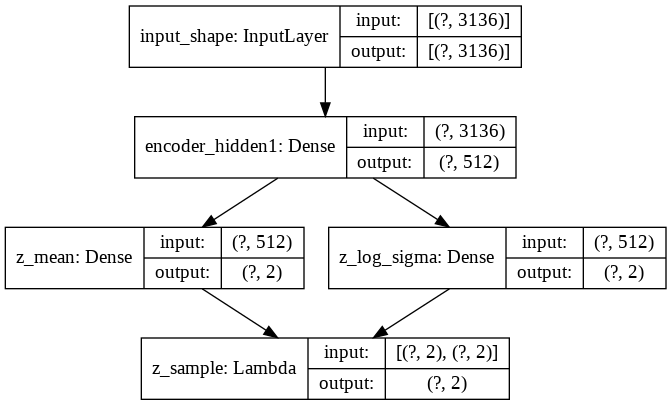

In [5]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
  encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

  # 평균(mean)과 표준편차(log_sigma)층을 정의합니다. 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
  z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(encoder_hidden)

  # 평균과 표준편차를 래핑하여 Z_sampling층을만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_sigma])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.   
  return Model(inputs,[z_mean,z_log_sigma,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Decoder 생성

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_z (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 512)               1536      
_________________________________________________________________
output (Dense)               (None, 3136)              1608768   
Total params: 1,610,304
Trainable params: 1,610,304
Non-trainable params: 0
_________________________________________________________________


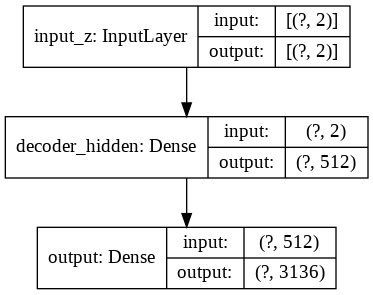

In [6]:
def decoder():
  
  # 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
  decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

  # 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

VAE모델 생성

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 3136)]            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1608196   
_________________________________________________________________
decoder (Model)              (None, 3136)              1610304   
Total params: 3,218,500
Trainable params: 3,218,500
Non-trainable params: 0
_________________________________________________________________


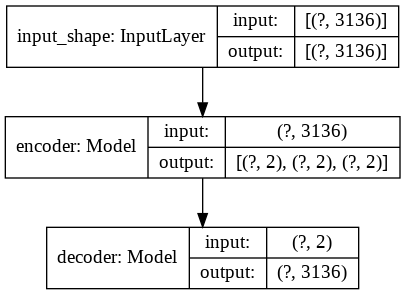

In [7]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.  
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_sigma,[2]:z_sampling
  
  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인 
model.summary()
plot_model(model,to_file='vae_mlp.png',show_shapes=True)

## model fit으로 모델학습 

In [0]:
# Hyperparameters
num_epochs = 100
batch_size = 20
learning_rate = 1e-3

In [0]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    z_mean,z_log_sigma,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_sigma)- 2*z_log_sigma -1, 1)    
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [20]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장 
model.save_weights('vae_bracket.h5')

Train on 2400 samples
Epoch 1/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1318.1286
Epoch 2/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1265.0135
Epoch 3/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1273.9201
Epoch 4/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1264.0325
Epoch 5/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1262.6207
Epoch 6/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1260.8375
Epoch 7/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1259.6047
Epoch 8/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1260.8858
Epoch 9/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1257.4907
Epoch 10/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1256.3463
Epoch 11/100
2400/2400 [==============================] - 3s 1ms/sample - loss: 1251.54

## 원본이미지와 복원이미지 비교

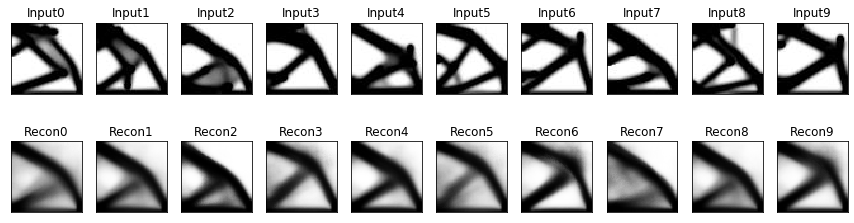

In [13]:
recon_x_test = model.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

## 2D공간에 잠재된 데이터 출력

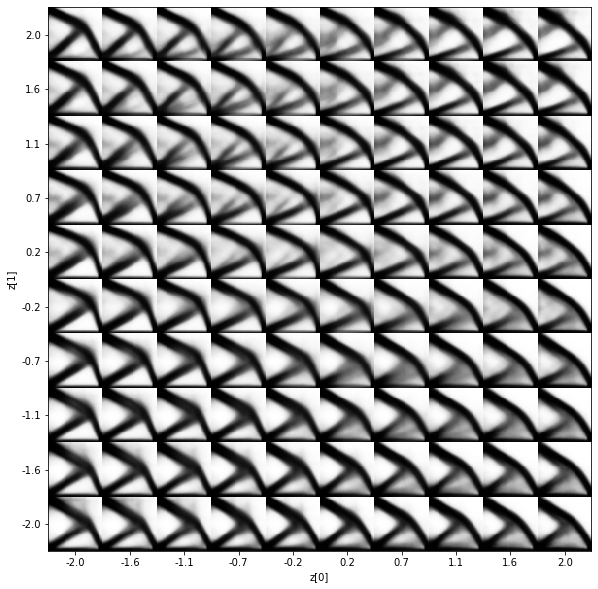

In [21]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 10
    digit_size = 56
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

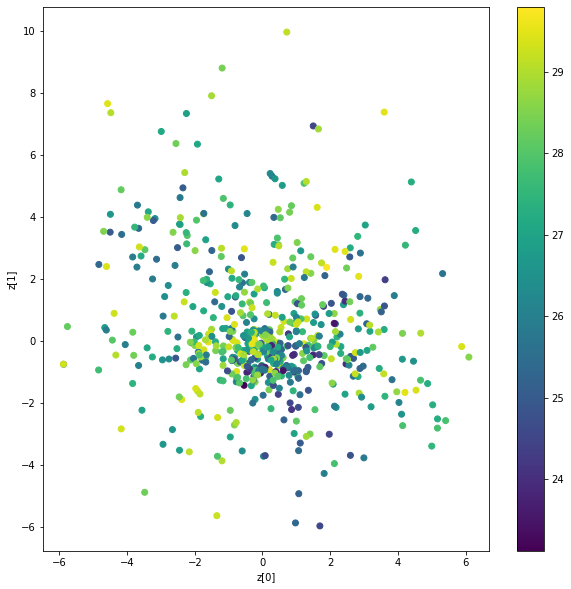

In [22]:
def tsne_plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    filename = "vae_mean.png"
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

tsne_plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

## 데이터 간 Interpolation

In [0]:
def linear_interpolation(x_from, x_to, steps=10):
    n = steps + 1

    t_from = x_from
    t_to = x_to

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decoder.predict(inter)

In [0]:
target_a = np.array([1, 1]) # 타겟 시작 좌표 
target_b = np.array([10, 10]) # 타겟 끝 좌표
z_decoder_imgs = linear_interpolation(target_a,target_b, 10)

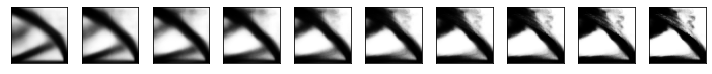

In [25]:
N = 1
M = 10
img_size= 56
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(np.reshape(z_decoder_imgs[k], (img_size, img_size)), cmap=plt.cm.gist_gray)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()

## Reference
*   https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko
*   https://www.tensorflow.org/tutorials/generative/cvae